In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Fortuna 0-2 Ajax.csv")

# Define offensive and defensive event type IDs
OFFENSIVE_EVENTS = {1, 3, 13, 14, 15, 16}  # Example: shot, key pass, dribble, cross
DEFENSIVE_EVENTS = {7, 8, 44, 45, 49, 12}  # Example: tackle, interception, clearance, block

# Add boolean columns for offensive and defensive actions
df['is_offensive'] = df['typeId'].isin(OFFENSIVE_EVENTS).astype(int)
df['is_defensive'] = df['typeId'].isin(DEFENSIVE_EVENTS).astype(int)

# Count player-specific offensive and defensive events within each contestantId
player_stats = df.groupby(['contestantId', 'playerName']).agg(
    offensive_events=('is_offensive', 'sum'),
    defensive_events=('is_defensive', 'sum')
).reset_index()

# Calculate team total offensive and defensive events per contestantId
team_stats = df.groupby('contestantId').agg(
    team_offensive_total=('is_offensive', 'sum'),
    team_defensive_total=('is_defensive', 'sum')
).reset_index()

# Merge team totals with player stats
player_stats = player_stats.merge(team_stats, on='contestantId')

# Compute usage percentages
player_stats['offensive_usage'] = (player_stats['offensive_events'] / player_stats['team_offensive_total']) * 100
player_stats['defensive_usage'] = (player_stats['defensive_events'] / player_stats['team_defensive_total']) * 100

# Replace NaN values with 0 (if a team has zero offensive/defensive events)
player_stats.fillna(0, inplace=True)

# Display results
print(player_stats)


                 contestantId       playerName  offensive_events  \
0   3ebril33e08ddzob4bhq8awsr     A. Halilović                40   
1   3ebril33e08ddzob4bhq8awsr  Alessio da Cruz                17   
2   3ebril33e08ddzob4bhq8awsr     B. Radulović                 6   
3   3ebril33e08ddzob4bhq8awsr       D. Grujčić                 8   
4   3ebril33e08ddzob4bhq8awsr    D. Sinkgraven                15   
5   3ebril33e08ddzob4bhq8awsr      E. Bullaude                 4   
6   3ebril33e08ddzob4bhq8awsr      J. Dahlhaus                 2   
7   3ebril33e08ddzob4bhq8awsr      J. Mitrović                32   
8   3ebril33e08ddzob4bhq8awsr      K. Peterson                23   
9   3ebril33e08ddzob4bhq8awsr      L. Koopmans                35   
10  3ebril33e08ddzob4bhq8awsr        L. Rosier                46   
11  3ebril33e08ddzob4bhq8awsr         M. Dijks                43   
12  3ebril33e08ddzob4bhq8awsr         R. Fosso                26   
13  3ebril33e08ddzob4bhq8awsr       S. Adewoye  

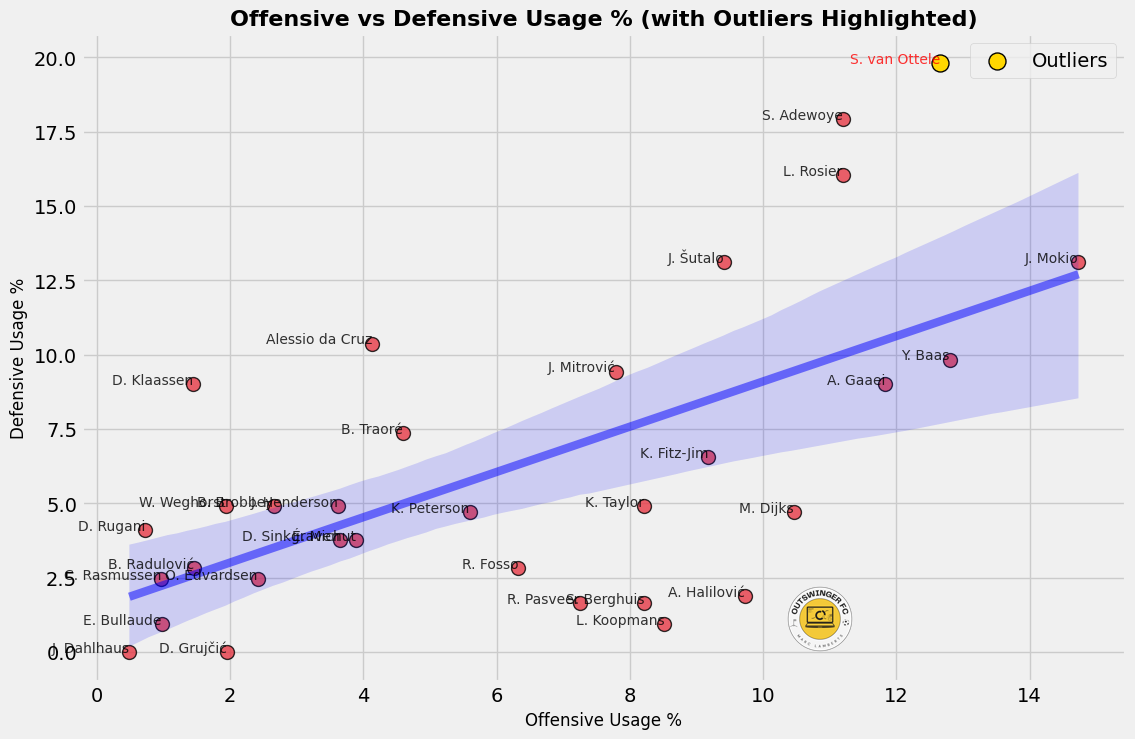

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load the dataset
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Fortuna 0-2 Ajax.csv")

# Define offensive and defensive event type IDs
OFFENSIVE_EVENTS = {1, 3, 13, 14, 15, 16}
DEFENSIVE_EVENTS = {7, 8, 44, 45, 49, 12}

# Add boolean columns
df['is_offensive'] = df['typeId'].isin(OFFENSIVE_EVENTS).astype(int)
df['is_defensive'] = df['typeId'].isin(DEFENSIVE_EVENTS).astype(int)

# Aggregate player stats
player_stats = df.groupby(['contestantId', 'playerName']).agg(
    offensive_events=('is_offensive', 'sum'),
    defensive_events=('is_defensive', 'sum')
).reset_index()

# Aggregate team totals
team_stats = df.groupby('contestantId').agg(
    team_offensive_total=('is_offensive', 'sum'),
    team_defensive_total=('is_defensive', 'sum')
).reset_index()

# Merge player stats with team totals
player_stats = player_stats.merge(team_stats, on='contestantId')

# Calculate usage percentages
player_stats['offensive_usage'] = (player_stats['offensive_events'] / player_stats['team_offensive_total']) * 100
player_stats['defensive_usage'] = (player_stats['defensive_events'] / player_stats['team_defensive_total']) * 100
player_stats.fillna(0, inplace=True)  # Handle division by zero

# Calculate IQR for outlier detection
Q1_off, Q3_off = player_stats["offensive_usage"].quantile([0.25, 0.75])
Q1_def, Q3_def = player_stats["defensive_usage"].quantile([0.25, 0.75])

IQR_off = Q3_off - Q1_off
IQR_def = Q3_def - Q1_def

# Define outlier conditions
outlier_condition = (
    (player_stats["offensive_usage"] < (Q1_off - 1.5 * IQR_off)) | (player_stats["offensive_usage"] > (Q3_off + 1.5 * IQR_off)) |
    (player_stats["defensive_usage"] < (Q1_def - 1.5 * IQR_def)) | (player_stats["defensive_usage"] > (Q3_def + 1.5 * IQR_def))
)

# Mark outliers
player_stats["is_outlier"] = outlier_condition

# Set FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Scatterplot with regression line
sns.regplot(
    data=player_stats,
    x="offensive_usage",
    y="defensive_usage",
    scatter_kws={"s": 100, "color": "#E63946", "edgecolor": "black"},
    line_kws={"alpha": 0.5, "color": "blue"},
    ax=ax
)

# Highlight outliers in a different color
outliers = player_stats[player_stats["is_outlier"]]
sns.scatterplot(
    data=outliers,
    x="offensive_usage",
    y="defensive_usage",
    s=150,
    color="gold",
    edgecolor="black",
    label="Outliers",
    ax=ax
)

# Add player names as annotations
for _, row in player_stats.iterrows():
    color = "black" if not row["is_outlier"] else "red"
    ax.annotate(row['playerName'], (row['offensive_usage'], row['defensive_usage']), fontsize=10, ha='right', alpha=0.8, color=color)

# Titles and labels
ax.set_title("Offensive vs Defensive Usage % (with Outliers Highlighted)", fontsize=16, fontweight='bold')
ax.set_xlabel("Offensive Usage %", fontsize=12)
ax.set_ylabel("Defensive Usage %", fontsize=12)

# Load and resize logo
logo_path = "Data visuals/Outswinger FC (3).png"
logo = Image.open(logo_path)
logo.thumbnail((80, 80))  # Resize logo

# Add logo to top-right corner
ax.figure.figimage(logo, xo=780, yo=80, alpha=0.9, zorder=10)  # Adjust position

# Show plot
plt.legend()
plt.show()
